In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline

from cataclop.ml.pipeline import factories

In [256]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
MAX_HISTORY = 6
NAN_FLAG = 10000.

In [3]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [4]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,138408.0,5.023770e+00,2.013027e+00,1.0,3.00,5.0,6.0,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,138408.0,1.233263e+01,3.128411e+00,3.0,10.00,12.0,15.0,2.400000e+01,int64
distance,138408.0,1.928350e+03,4.998067e+02,800.0,1600.00,2000.0,2300.0,6.856000e+03,int64
earnings,138408.0,5.909599e+06,1.784700e+07,0.0,490000.00,2027500.0,6045000.0,1.471275e+09,int64


In [5]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight',
                'final_odds_ref'
               ] + ['hist_{}_pos'.format(i+1) for i in range(MAX_HISTORY)]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_features:
    df['{}_r'.format(f)] = (df[f] - df['{}_mean'.format(f)]) / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features if f != 'final_odds_ref'] + ['{}_std'.format(f) for f in agg_features] + ['{}_mean'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(NAN_FLAG)


In [6]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

start = time.time()

odds = np.ones([len(df), 20]) * NAN_FLAG
idx = []

races = df.groupby('race_id')

j = 0
for (id, race) in races:
    jj = len(race.index)
    odds_sorted = np.array(sorted(race[race['final_odds_ref']>1.]['final_odds_ref'].values))
    
    
    
    odds[j:j+jj, 0:len(odds_sorted)] = odds_sorted[:20]
    
    idx = idx + list(race.index)
    
    j = j + jj
    
#scaler = StandardScaler()
#odds = scaler.fit_transform(odds)
    
odds_df = pd.DataFrame(odds, columns=['odds_{:d}'.format(i) for i in range(20)], index=idx)
df = pd.concat([df,odds_df], axis=1)

end = time.time()
print(end - start)

33.607139110565186


In [7]:
print(df['start_at'].min(), df['start_at'].max())

2017-01-01 12:40:00 2018-06-22 21:24:00


In [8]:
df['speed'] = (df['distance'] / df['time']).fillna(NAN_FLAG)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(NAN_FLAG)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.groupby('race_id').filter(lambda r: r['final_odds_ref'].min() > 0)
df = df.sort_index()
df_orig = df.copy()

In [9]:
#df_test = df_orig[(df_orig['start_at'] > '2018-06-01') & (df_orig['category']=='PLAT')].copy()
df_test = df_orig[(df_orig['start_at'] > '2018-06-07')].copy()
df = df_orig[(df_orig['start_at'] <= '2018-06-06')].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [10]:
pd.concat([pd.DataFrame(df.describe()).T, df.dtypes], axis=1, sort=True)

dff = df.reset_index()
pd.concat([pd.DataFrame(dff.describe()).T, dff.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,106780.0,5.036346e+00,2.025373e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,106780.0,1.243496e+01,3.162771e+00,3.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,2.400000e+01,int64
distance,106780.0,1.926085e+03,5.155121e+02,8.000000e+02,1.500000e+03,2.000000e+03,2.300000e+03,6.856000e+03,int64
earnings,106780.0,6.188416e+06,1.809054e+07,0.000000e+00,6.241552e+05,2.365000e+06,6.572000e+06,1.389165e+09,int64


In [11]:
def random_race(df, cols=None, n=1):

    if cols is None:
        cols = ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_r', 'final_odds_ref', 'hist_1_pos', 'hist_1_pos_r', 'hist_1_pos_mean', 'hist_1_pos_std', 'odds_0', 'odds_1']

    return df.reset_index().set_index(['race_id', 'index']).loc[np.random.permutation(df['race_id'].unique())[0:n]][cols]
    

In [12]:
random_race(df)

position sub_category  num  final_odds  final_odds_ref_r  \
race_id index                                                              
18805   131964       7.0     HANDICAP    1         4.8         -0.818578   
        131965       1.0     HANDICAP    2         7.5         -0.125083   
        131966       5.0     HANDICAP    3         3.4         -0.400581   
        131967       3.0     HANDICAP    4        27.3          0.421164   
        131968       4.0     HANDICAP    5         2.2         -0.870828   
        131969       2.0     HANDICAP    6       118.3               NaN   
        131970       6.0     HANDICAP    7        15.4          1.793906   

                final_odds_ref  hist_1_pos  hist_1_pos_r  hist_1_pos_mean  \
race_id index                                                               
18805   131964             2.7         0.0     -1.380585         3.714286   
        131965            17.3         5.0      0.477895         3.714286   
        131966            11.5         1.0     -1.008889         3.714286   
        131967            28.8         4.0      0.106199         3.714286   
        131968             1.6         3.0     -0.265497         3.714286   
        131969             NaN         8.0      1.592983         3.714286   
        131970            57.7         5.0      0.477895         3.714286   

                hist_1_pos_std  odds_0  odds_1  
race_id index                                   
18805   131964        2.690371     1.6     2.7  
        131965        2.690371     1.6     2.7  
        131966        2.690371     1.6     2.7  
        131967        2.690371     1.6     2.7  
        131968        2.690371     1.6     2.7  
        131969        2.690371     1.6     2.7  
        131970        2.690371     1.6     2.7

In [15]:
features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(10)]

#features = ['odds_{:d}'.format(i) for i in range(10)]

features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'final_odds_ref_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'final_odds_ref_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 '

In [16]:
pd.options.display.max_columns = 200

In [17]:
random_race(df, ['final_odds_ref', 'winner_dividend'] + features)

final_odds_ref  winner_dividend  race_count_r  victory_count_r  \
race_id index                                                                   
3452    23628             3.1              0.0      0.618590         0.053774   
        23629            11.3              0.0     -1.360897        -0.914166   
        23630             5.8              0.0      0.288675         1.667008   
        23631            16.9              0.0     -0.646082        -0.268872   
        23632            16.3              0.0     -0.756054        -0.591519   
        23633            32.2              0.0      1.718304         2.312302   
        23634            14.5              0.0      1.278418         0.376421   
        23635            22.5              0.0     -0.975997        -0.591519   
        23636             6.2            690.0      1.113461        -0.268872   
        23637            17.8              0.0     -0.701068        -0.591519   
        23638            22.7              0.0      0.068732        -0.591519   
        23639            13.7              0.0     -0.646082        -0.591519   

               placed_2_count_r  placed_3_count_r  victory_earnings_r  \
race_id index                                                           
3452    23628          0.866298          1.608681            1.732188   
        23629         -0.662463         -1.305157           -0.926256   
        23630          0.560546          0.515992            0.903331   
        23631         -0.356711         -0.576697           -0.463317   
        23632         -0.968215         -0.576697           -0.682398   
        23633          1.477802          0.515992            0.247392   
        23634          1.783555         -0.212467            1.460266   
        23635         -0.968215         -0.940927           -0.957554   
        23636          0.560546          1.972911            0.882466   
        23637         -0.968215         -0.576697           -0.862619   
        23638         -0.662463          0.151762           -0.418979   
        23639         -0.662463         -0.576697           -0.914520   

               prev_year_earnings_r  handicap_distance_r  handicap_weight_r  \
race_id index                                                                 
3452    23628              2.083240              10000.0           1.344362   
        23629             -0.250064              10000.0           1.344362   
        23630              1.276099              10000.0           1.021715   
        23631              0.129602              10000.0           0.699068   
        23632             -0.517236              10000.0           0.376421   
        23633             -1.187510              10000.0           0.376421   
        23634              0.860810              10000.0           0.053774   
        23635             -1.196885              10000.0          -0.914166   
        23636              0.204598              10000.0          -0.914166   
        23637             -0.354120              10000.0          -0.914166   
        23638             -0.086011              10000.0          -1.236813   
        23639             -0.962523              10000.0          -1.236813   

               hist_1_pos_r  hist_2_pos_r  hist_3_pos_r  hist_4_pos_r  \
race_id index                                                           
3452    23628     -0.337721      0.777805      1.176685     -0.349603   
        23629      1.463457     -1.088927     -1.424409      0.000000   
        23630     -0.788015     -1.088927     -0.681239     -1.398412   
        23631     -1.238309      1.151151      0.433516      0.349603   
        23632     -1.688604     -0.715581     -0.309654      0.349603   
        23633      0.562868     -1.088927      0.061931      1.398412   
        23634     -0.337721     -0.715581      0.805101      0.000000   
        23635      0.562868      0.777805     -1.052824     -0.349603   
        23636      1

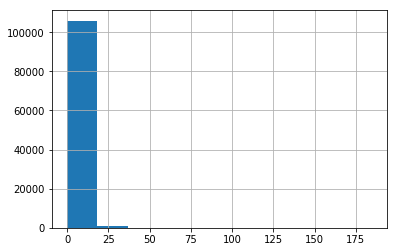

In [18]:

N_TARGETS = 20

df['target'] = np.log(1.+df['position'].copy())
df.loc[df['target'] > N_TARGETS, 'target'] = np.log(1.+N_TARGETS)
df['target'].fillna(NAN_FLAG, inplace=True)

#df['target'] = df['final_odds_ref'].fillna(df['final_odds_ref'].mean())

#df['target'] = df['winner_dividend'].fillna(0.)

#df['target'].fillna( NAN_FLAG, inplace=True )


#df['target'] = df['winner_dividend']/100.

#df['target'].fillna(NAN_FLAG, inplace=True)

df['target'] = df['winner_dividend'].fillna(0.)/100.

df['target'].hist()



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=2)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'knn_5',
        'model': KNeighborsRegressor(n_neighbors=5),
        'scaler': True
    },
    {
        'name': 'knn_10',
        'model': KNeighborsRegressor(n_neighbors=10),
        'scaler': True
    },
    {
        'name': 'knn_30',
        'model': KNeighborsRegressor(n_neighbors=30),
        'scaler': True
    },
    {
        'name': 'knn_90',
        'model': KNeighborsRegressor(n_neighbors=150),
        'scaler': True
    },
    {
        'name': 'rf_10',
        'model': RandomForestRegressor(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestRegressor(n_estimators=100),
        'scaler': False
    },
]

for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0


In [20]:

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)

        X_train = X_train[ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]
        y_train = df['target'].iloc[train_index][ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            #X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        '''
        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]
        '''
        
        p = clf.predict(X_test)
        
        df.loc[idx, 'pred_{}_1'.format(model['name'])] = p
        
        print( model['name'], mean_absolute_error(y_test.values, p) )
    
    
    
    

knn_5 1.4795148904289193
knn_10 1.4738527814197415
knn_30 1.4656112255728286
knn_90 1.466316051695074
rf_10 1.7567167574792693
rf_100 1.748085296657152
knn_5 1.4386192170818504
knn_10 1.441857463944559
knn_30 1.444917649996878
knn_90 1.4399372416807141
rf_10 1.7686259371333544
rf_100 1.7755490683421697


In [21]:
races = df.groupby('race_id')

N_TARGETS = 1

agg_preds = []

for i in range(N_TARGETS):
    for model in models:
        for s in ['mean', 'std', 'r']:
            col = 'pred_{}_{}_{}'.format(model['name'], i+1, s)
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
        
for i in range(N_TARGETS):
    for model in models:
        col = 'pred_{}_{}'.format(model['name'], i+1)
        agg_preds.append(col)
        
stats = races[agg_preds].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_preds:
    col = '{}_r'.format(f)
    df[col] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_preds = ['{}_r'.format(f) for f in agg_preds] + ['{}_std'.format(f) for f in agg_preds] + ['{}_mean'.format(f) for f in agg_preds]

df[agg_preds] = df[agg_preds].replace([np.inf, -np.inf], np.nan)
df[agg_preds] = df[agg_preds].fillna(NAN_FLAG)


In [22]:
random_race(df, ['final_odds', 'position', 'final_odds_ref', 'final_odds', 'target'] + ['pred_{}_1'.format(model['name']) for model in models] +  ['pred_{}_1_mean'.format(model['name']) for model in models])

final_odds  position  final_odds_ref  final_odds  target  \
race_id index                                                             
5754    39846         9.3       7.0             7.5         9.3     0.0   
        39848        37.9       6.0            40.0        37.9     0.0   
        39849         7.9       1.0            17.6         7.9     9.6   
        39850        16.2       NaN            14.2        16.2     0.0   
        39851        77.4       NaN            33.7        77.4     0.0   
        39852        51.0       NaN            12.8        51.0     0.0   
        39853        26.8       4.0             9.3        26.8     0.0   
        39854         1.9       3.0             2.8         1.9     0.0   
        39855        61.6       2.0            35.8        61.6     0.0   
        39856        43.4       NaN            33.7        43.4     0.0   
        39857        10.9       5.0             9.6        10.9     0.0   
        39858        20.4       8.0            10.6        20.4     0.0   
        39859        11.5       NaN            12.8        11.5     0.0   
        39860       100.0       NaN            60.1       100.0     0.0   

               pred_knn_5_1  pred_knn_10_1  pred_knn_30_1  pred_knn_90_1  \
race_id index                                                              
5754    39846          1.60           1.31       1.066667       0.887333   
        39848          1.60           0.80       0.446667       0.964667   
        39849          3.96           1.98       1.190000       1.077333   
        39850          3.96           1.98       1.176667       0.888000   
        39851          3.96           1.98       1.176667       0.888000   
        39852          3.96           1.98       1.176667       0.888000   
        39853          1.38           1.25       1.873333       0.911333   
        39854          0.00           0.00       1.450000       0.872667   
        39855          2.62           1.31       0.660000       0.586667   
        39856          3.96           1.98       1.190000       1.086000   
        39857          0.00           0.00       0.266667       0.899333   
        39858          1.68           1.13       1.463333       0.740000   
        39859          3.96           1.98       1.000000       0.942667   
        39860          1.60           0.80       0.676667       0.837333   

               pred_rf_10_1  pred_rf_100_1  pred_knn_5_1_mean  \
race_id index                                                   
5754    39846          0.00       1.376000           2.445714   
        39848          2.26       0.904000           2.445714   
        39849          0.24       0.752333           2.445714   
        39850          0.48       0.652000           2.445714   
        39851          0.00       1.025000           2.445714   
        39852          1.60       1.144000           2.445714   
        39853          1.77       1.007000           2.445714   
        39854          0.00       1.279333           2.445714   
        39855          3.88       1.197000           2.445714   
        39856          1.77       0.974000           2.445714   
        39857          2.22       1.455000           2.445714   
        39858          9.97       1.210000           2.445714   
        39859          1.81       1.330000           2.445714   
        39860          0.80       1.345000           2.445714   

               pred_knn_10_1_mean  pred_knn_30_1_mean  pred_knn_90_1_mean  \
race_id index                                                               
5754    39846                1.32            1.058095            0.890667   
        39848                1.32            1.058095            0.890667   
        39849                1.32            1.058095            0.890667   
        39850                1.32            1.058095            0.890667   
        39851                1.32            1.058095            0.890667   
        39852    

In [253]:
features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'final_odds_ref_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'final_odds_ref_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 '

In [254]:
stacked_features = ['final_odds_ref', 'declared_player_count', 'final_odds_ref_std'] + ['odds_{:d}'.format(i) for i in range(10)]
df['final_odds_ref'].fillna(NAN_FLAG, inplace=True)

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features + agg_preds# + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]

stacked_features =   stacked_features

stacked_features



['final_odds_ref',
 'declared_player_count',
 'final_odds_ref_std',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'pred_knn_5_1',
 'pred_knn_10_1',
 'pred_knn_30_1',
 'pred_knn_90_1',
 'pred_rf_10_1',
 'pred_rf_100_1',
 'pred_knn_5_1_r',
 'pred_knn_10_1_r',
 'pred_knn_30_1_r',
 'pred_knn_90_1_r',
 'pred_rf_10_1_r',
 'pred_rf_100_1_r',
 'pred_knn_5_1_std',
 'pred_knn_10_1_std',
 'pred_knn_30_1_std',
 'pred_knn_90_1_std',
 'pred_rf_10_1_std',
 'pred_rf_100_1_std',
 'pred_knn_5_1_mean',
 'pred_knn_10_1_mean',
 'pred_knn_30_1_mean',
 'pred_knn_90_1_mean',
 'pred_rf_10_1_mean',
 'pred_rf_100_1_mean']

In [26]:
from sklearn.linear_model import LogisticRegression
from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 20

df['target_stacked'] = df['position'].copy()

'''
df['target_stacked'] = df['target_stacked'] / df['declared_player_count']
df['target_stacked'].fillna(df['target_stacked'].mean(), inplace=True)
df['target_stacked'] = np.exp(1. + df['target_stacked'])
'''


#df['target_stacked'] = df['target_stacked'].apply(lambda r: 1 if r >= 1 and r <= 2 else r-1 if r > 2 else r  )

df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['target_stacked'] = df['target_stacked'].apply(lambda v: -1000 if v == 1 else v)


df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0

#df['target_stacked'] = np.ceil(1.+df['position'].fillna( 0. ))

df['target_stacked'] = df['winner_dividend'].fillna(0.)

#df['target_stacked'] = df['target'].copy()

df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [611]:
df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [266]:
from sklearn import linear_model

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]
    y_train = df['target_stacked'].iloc[train_index][(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]

    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    #X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    #X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    #X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #X_val = scaler.transform(X_val)
    
    '''
    clf = MLPClassifier(hidden_layer_sizes=(100), activation='tanh', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    #p = clf.predict_proba(X_val)
    
    #for i in range(N_TARGETS_STACKED):
    #    df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
    
    '''
       
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    
    #reg = linear_model.Ridge()
    #reg = SVR()
    reg = MLPRegressor(hidden_layer_sizes=(100), activation='relu')
    #reg = RandomForestRegressor(n_estimators=100)
    #reg = KNeighborsRegressor(n_neighbors=3, weights='distance')
    '''
    function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv', 'cos', 'sin',
                'max', 'min']
    from gplearn.fitness import make_fitness
    
    def _metric(y, y_pred, w):
        
        diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                             np.maximum(0.001, y)))
        return 100. * np.average(diffs, weights=w)        
    
    metric = make_fitness(_metric, greater_is_better=False)
    
    reg = SymbolicRegressor(function_set=function_set, 
                            verbose=True,
                            const_range=(-100, 100),
                            parsimony_coefficient=0.00001,
                            max_samples=0.8, metric=metric)
                        '''
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked_1'] = p
    
    print( mean_absolute_error(y_test.values, p) )





/Users/pourquoi/.local/share/virtualenvs/cataclop-U5iMB7x3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


10208955410.175842
262.4862036701432


In [269]:
random_race(df, cols=['position', 'final_odds_ref', 'winner_dividend', 'sub_category', 'target_stacked', 'pred_stacked_1', 'pred_stacked_2', 'pred_stacked_3']).sort_values('pred_stacked_1')

position  final_odds_ref  winner_dividend sub_category  \
race_id index                                                            
18591   130508       9.0            57.4              0.0    AUTOSTART   
        130509       NaN            51.8              0.0    AUTOSTART   
        130516       7.0            52.2              0.0    AUTOSTART   
        130507       1.0             4.1            410.0    AUTOSTART   
        130515       NaN            27.6              0.0    AUTOSTART   
        130511       NaN             6.7              0.0    AUTOSTART   
        130517       2.0            13.6              0.0    AUTOSTART   
        130505       4.0            10.4              0.0    AUTOSTART   
        130506       NaN            16.3              0.0    AUTOSTART   
        130504       5.0             5.8              0.0    AUTOSTART   
        130510       8.0            11.0              0.0    AUTOSTART   
        130514       3.0            16.3              0.0    AUTOSTART   
        130513       NaN            14.5              0.0    AUTOSTART   
        130512       6.0            13.4              0.0    AUTOSTART   

                target_stacked  pred_stacked_1  pred_stacked_2  pred_stacked_3  
race_id index                                                                   
18591   130508             0.0       62.631969             0.0             0.0  
        130509             0.0       65.144619             0.0             0.0  
        130516             0.0       67.398894             0.0             0.0  
        130507           410.0       74.794333             0.0             0.0  
        130515             0.0       88.782580             0.0             0.0  
        130511             0.0       88.858122             0.0             0.0  
        130517             0.0       91.477167             0.0             0.0  
        130505             0.0       93.925048             0.0             0.0  
        130506             0.0       94.590731             0.0             0.0  
        130504             0.0       95.999843             0.0             0.0  
        130510             0.0       98.823941             0.0             0.0  
        130514             0.0      104.519348             0.0             0.0  
        130513             0.0      111.084977             0.0             0.0  
        130512             0.0      111.886595             0.0             0.0

In [169]:
fi = pd.Series(reg.feature_importances_, index=stacked_features)
print(fi.sort_values(ascending=False))

AttributeError: 'KNeighborsRegressor' object has no attribute 'feature_importances_'

In [270]:
#df_test['rnd'] = np.random.rand(len(df_tes))

#df['strat_1'] = df['pred_knn_150_1'] + df['pred_knn_30_1'] + df['pred_knn_10_1'] + df['pred_knn_5_1']
df['strat_1'] = df['pred_stacked_1']#df['pred_knn_5_1'] + df['pred_knn_10_1'] + df['pred_knn_30_1'] + df['pred_knn_150_1']

races = df.sort_values('start_at').groupby('race_id')

strats = ['strat_1']

bets = []

stash = 500

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(strats, 1):
        
#        if len(nums) > 0:
#            break

        r = race.sort_values(by=target, ascending=False)
    
        #r = r[r['final_odds_ref']<40.]
        
        odds = r['final_odds_ref'].min()
        nth = len(r[r['final_odds_ref']<odds])+1
    
        N = 1


        for n in range(N):
            
            if len(r) <= N:
                continue

            player = r.iloc[n]

            if player['sub_category'] != 'COURSE_A_CONDITIONS':
                pass

            if player['num'] in nums:
                continue
                
            if player['pred_stacked_1'] <= 0:
                continue

            odds = player['final_odds_ref']
            nth = (r['final_odds_ref']<odds).sum()+1

            if np.isnan(odds) or odds > 20 or odds < 1:
                continue
                
            #if nth > 4:
            #    continue
                
            if race['final_odds_ref'].min() < 3:
                continue
                
            if race['final_odds_ref'].max() > 30:
                pass

            
            bet = min( 9., 1.5*np.floor(max(stash*0.01, 0.)) )
            
            bet = 1./player['declared_player_count']
            
            bet = np.floor(1+1/np.log(odds))
            
            bet = 1.# / player['final_odds_ref']
        
            profit = player['winner_dividend']/100.0 * bet - bet
            
            stash = stash + profit

            #print(player['sub_category'], player['country'], player['declared_player_count'], player['final_odds_ref'], race['final_odds_ref'].describe())

            bets.append( (id, race['race_count'].min(), player['sub_category'], player['country'], player[target], nth, player['declared_player_count'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], race['final_odds_ref'].std(), player['num'], profit) )

            nums.append(player['num'])
            
            if len(nums) >= 2:
                break



bets = pd.DataFrame(bets, columns=['id', 'race_count_min', 'cat', 'country', 'target', 'nth', 'n', 'date', 'bet', 'pos', 'odds', 'pred_1', 'num', 'odds_std', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


In [271]:
bets_orig = bets.copy()

In [272]:
#bets = bets_orig

In [276]:
from cataclop.ml.exploration import loss_streak

bets = bets[(bets['profit']>0) | (bets['pos'] != 1)]
bets = bets[bets['cat'] == 'HANDICAP']

print('from:', bets['date'].min(), 'to:', bets['date'].max())

print('loss streak:', loss_streak(bets))
print('bets:', (bets['bet']>0).sum())
print('bets:', bets['bet'].sum(), '€')
print('profits:', bets['profit'].sum(), '€')
print('returns:', 100. * (bets['profit'].sum() / bets['bet'].sum()), '%')
print('win rate:', 100. * (bets['profit']>0).astype('float').mean(), '%')

from: 2017-01-01 15:47:00 to: 2018-06-04 20:30:00
loss streak: 34
bets: 711
bets: 711.0 €
profits: 224.7 €
returns: 31.60337552742616 %
win rate: 14.20534458509142 %


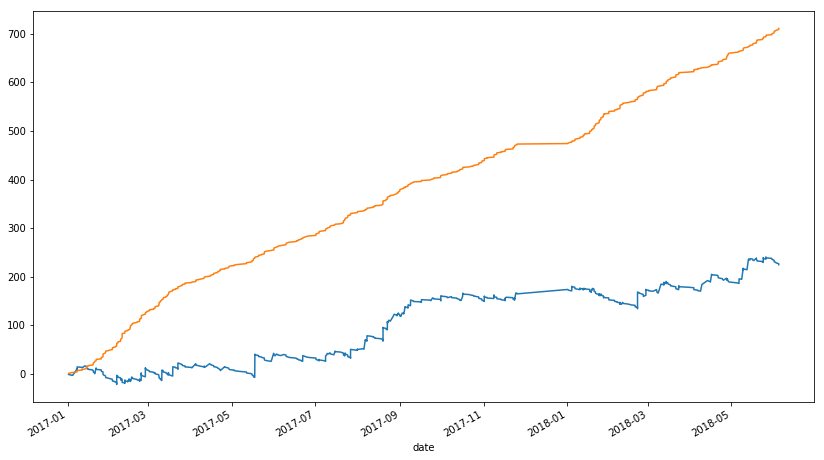

In [277]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

bb = bets.copy()#bets[(bets['nth']>1.) & (bets['cat']=='HANDICAP') & (bets['odds']>10)].copy()
bb = bets[(bets['nth']>0.) & (bets['n']>0) & (bets['odds']>0)].copy()

bb['stash'] = bb['profit'].cumsum()
bb['bets'] = bb['bet'].cumsum()

bb['stash'].plot()
bb['bets'].plot(figsize=(14,8))

cat     AMATEURS_AUTOSTART  AMATEURS_INTERNATIONALE_AUTOSTART  \
profit               0.152                               -1.0   
profit              25.000                                1.0   

cat     APPRENTIS_LADS_JOCKEYS_AUTOSTART  \
profit                          0.261765   
profit                         34.000000   

cat     APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART   AUTOSTART  A_RECLAMER  \
profit                                         0.05   -0.007494    0.050296   
profit                                         6.00  387.000000  338.000000   

cat     A_RECLAMER_AUTOSTART  COURSE_A_CONDITIONS  \
profit             -0.216667             0.033723   
profit              6.000000           685.000000   

cat     COURSE_A_CONDITION_QUALIF_HP  EUROPEENNE_AUTOSTART   GROUPE_I  \
profit                     -0.508696                  -0.8  -0.546154   
profit                     46.000000                  26.0  13.000000   

cat     GROUPE_II  GROUPE_III    HANDICAP  HANDICAP_A

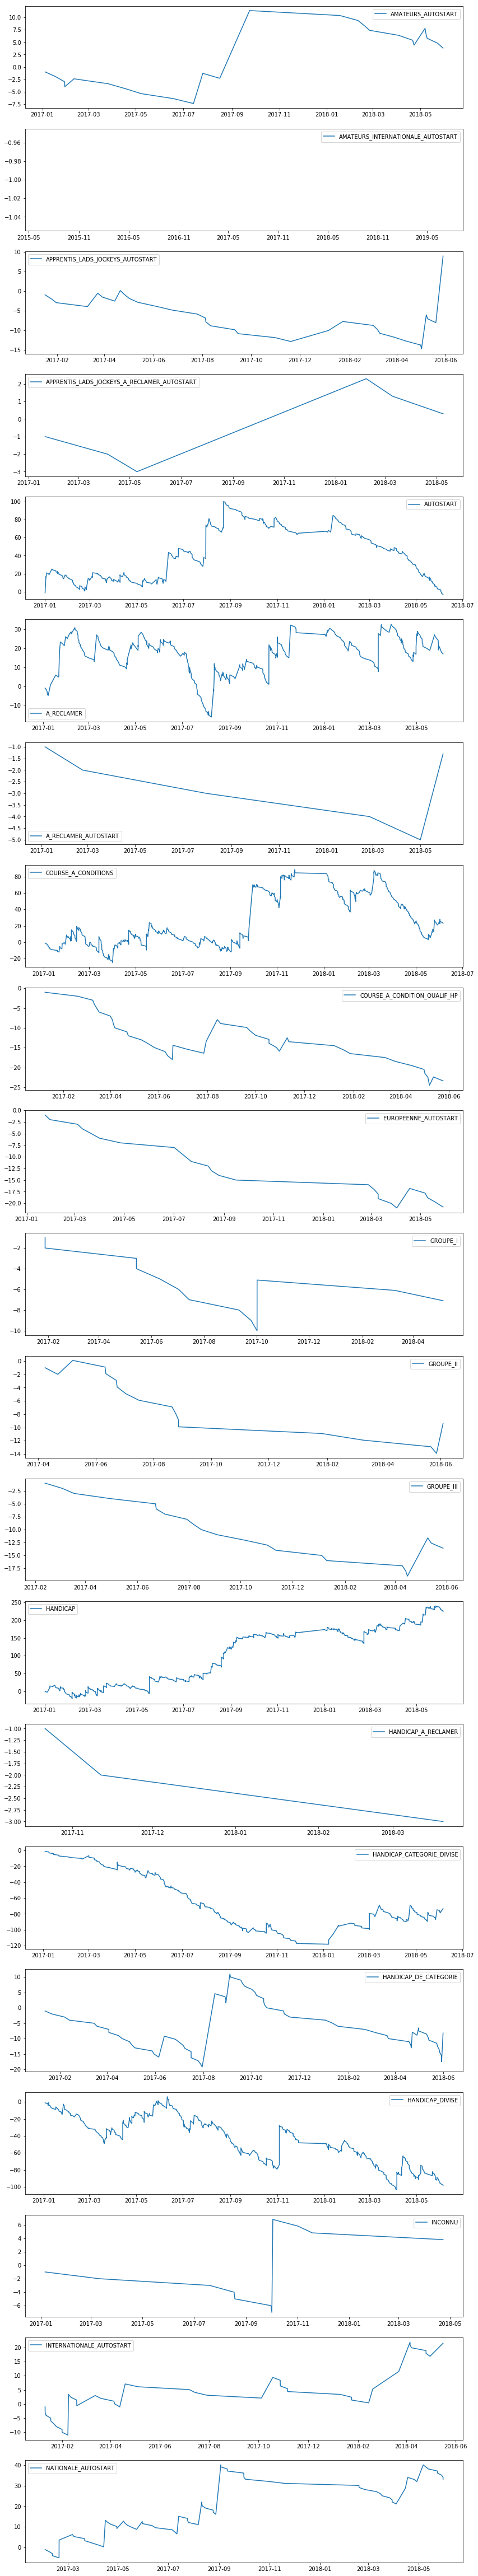

In [275]:
x = bb.index

bets_cat = bb.groupby('cat')

fig, axs = plt.subplots(len(bets_cat), 1, figsize=(14,4*len(bets_cat)))

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

i = 0
for cat, b in bets_cat:
    d = b['profit'].cumsum()
    x = d.index
    y = d.values
    axs[i].plot(x, y, label=cat);
    axs[i].legend();
    #(b['profit'].cumsum()).plot(label=cat, subplots=True, ax=axs[i])
    i = i + 1
    


In [235]:
b.index


DatetimeIndex(['2017-01-02 15:22:00', '2017-01-04 13:00:00',
               '2017-01-06 17:55:00', '2017-01-18 13:25:00',
               '2017-01-22 15:25:00', '2017-01-29 13:35:00',
               '2017-01-29 20:00:00', '2017-02-10 14:23:00',
               '2017-02-18 13:24:00', '2017-02-22 21:15:00',
               '2017-03-05 17:12:00', '2017-03-21 19:48:00',
               '2017-03-26 12:20:00', '2017-04-17 13:26:00',
               '2017-04-23 16:20:00', '2017-05-07 20:05:00',
               '2017-05-13 21:55:00', '2017-05-23 22:47:00',
               '2017-05-30 21:26:00', '2017-06-13 22:45:00',
               '2017-06-17 20:00:00', '2017-07-06 13:10:00',
               '2017-07-11 23:13:00', '2017-07-13 20:20:00',
               '2017-07-25 19:48:00', '2017-07-27 12:55:00',
               '2017-08-16 13:27:00', '2017-09-01 19:28:00',
               '2017-09-23 20:50:00', '2017-11-19 13:44:00',
               '2017-11-26 13:28:00', '2018-01-03 12:57:00',
               '2018-01-

In [247]:
bets[['id', 'cat', 'pos', 'odds', 'pred_1', 'profit', 'bet']][bets['cat']=='AUTOSTART']

,id,cat,pos,odds,pred_1,profit,bet
date,,,,,,,
2017-01-01 14:27:00,12360,AUTOSTART,1.0,4.1,88.811257,3.2,1.0
2017-01-02 13:47:00,12384,AUTOSTART,10.0,13.0,97.227419,-1.0,1.0
2017-01-02 17:12:00,12406,AUTOSTART,3.0,7.0,111.829323,-1.0,1.0
2017-01-02 17:42:00,12407,AUTOSTART,5.0,3.8,89.443206,-1.0,1.0
2017-01-02 20:42:00,12413,AUTOSTART,1.0,10.3,75.788388,6.8,1.0
2017-01-03 16:30:00,12428,AUTOSTART,NaN,18.7,97.212552,-1.0,1.0
2017-01-04 18:24:00,12489,AUTOSTART,1.0,2.8,93.804656,1.3,1.0
2017-01-05 20:15:00,12529,AUTOSTART,NaN,27.2,100.709509,-1.0,1.0
2017-01-06 20:29:00,12565,AUTOSTART,3.0,9.0,86.929261,-1.0,1.0


In [555]:
bets['nth_r'] = bets['nth'] / bets['n']
bets[bets['profit']>0].describe()

,id,race_count_min,target,nth,n,bet,pos,odds,pred_1,num,odds_std,profit,bets,stash,nth_r
count,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.0,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000
mean,10192.978158,6.426401,0.881876,3.071225,10.708452,1.794872,1.0,7.021462,0.881876,31.354625,5.054131,6.958215,5782.771130,-1188.455935,0.293932
std,5677.036916,9.817031,0.293941,3.084929,2.952330,1.944499,0.0,9.964196,0.293941,233.557110,3.514489,11.068387,3341.472591,643.833186,0.258424
min,2.000000,0.000000,-0.396387,1.000000,4.000000,1.000000,1.0,1.100000,-0.396387,1.222020,1.000000,0.200000,1.000000,-2239.100000,0.050000
25%,5309.000000,0.000000,0.670629,1.000000,9.000000,1.000000,1.0,2.500000,0.670629,8.204734,2.000000,2.400000,2955.000000,-1664.500000,0.100000
50%,10448.000000,3.000000,0.915428,2.000000,11.000000,1.000000,1.0,3.900000,0.915428,13.207647,5.000000,3.900000,5921.000000,-1407.100000,0.181818
75%,15069.000000,8.000000,1.103573,4.000000,12.000000,2.000000,1.0,7.200000,1.103573,21.606266,7.000000,6.900000,8735.000000,-788.600000,0.400000
max,19814.000000,71.000000,1.646284,18.000000,20.000000,11.000000,1.0,116.800000,1.646284,5218.118388,18.000000,146.000000,11452.000000,120.300000,1.000000


In [446]:
bets[bets['profit']<0].describe()

,id,race_count_min,target,nth,n,bet,pos,odds,pred_1,num,odds_std,profit,bets,stash,nth_r
count,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000,8102.000000,8804.000000,8805.000000,8.805000e+03,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000
mean,10119.133901,6.823964,5.422371,6.936286,11.619307,0.089740,6.534683,30.301840,5.422371,1.606159e+01,6.646451,-0.089740,471.329983,-104.201959,0.600811
std,5608.114916,9.417141,1.720070,3.740462,3.215985,0.095418,3.210812,31.168135,1.720070,1.499637e+01,3.922645,0.095418,279.985778,52.279830,0.271836
min,1.000000,0.000000,-2.081153,1.000000,3.000000,0.001197,2.000000,1.100000,-2.081153,9.729507e-16,1.000000,-0.909091,0.055292,-180.234575,0.050000
25%,5358.000000,1.000000,4.400418,4.000000,9.000000,0.034364,4.000000,9.100000,4.400418,8.123401e+00,3.000000,-0.108696,220.383715,-141.728975,0.375000
50%,10257.000000,4.000000,5.449340,7.000000,11.000000,0.061350,6.000000,18.800000,5.449340,1.239029e+01,6.000000,-0.061350,467.741398,-130.425106,0.625000
75%,14841.000000,9.000000,6.646244,9.000000,14.000000,0.108696,9.000000,40.900000,6.646244,1.936627e+01,9.000000,-0.034364,717.645782,-56.964969,0.833333
max,19830.000000,75.000000,10.560480,23.000000,24.000000,0.909091,19.000000,374.600000,10.560480,3.089419e+02,18.000000,-0.001197,958.833369,3.581412,1.000000


In [106]:
bets[bets['odds']>15]['profit'].describe()

count    350.000000
mean       0.230286
std        5.265838
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       35.200000
Name: profit, dtype: float64

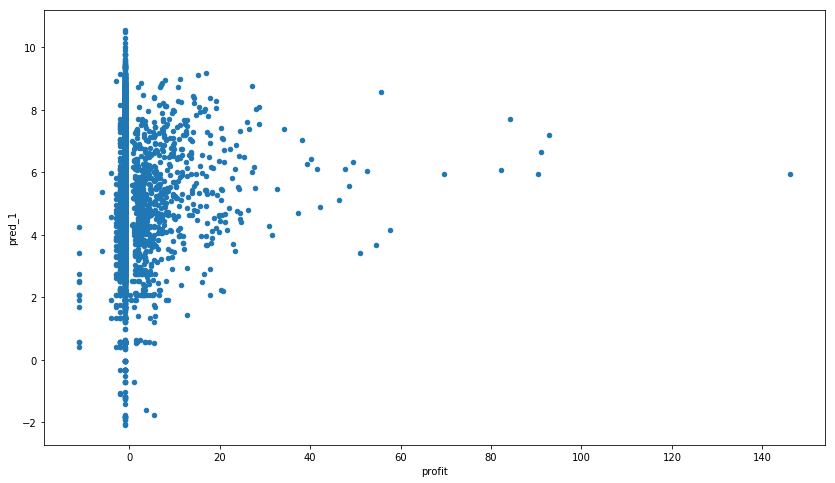

In [453]:
bets.plot.scatter(x='profit', y='pred_1', figsize=(14,8))

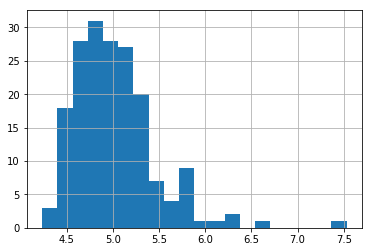

In [559]:
bets['pred_1'].hist(bins=20)

In [868]:
df[df['race_id']==4919][['position', 'winner_dividend']]

,position,winner_dividend
id,,
33925,7.0,0.0
33926,4.0,0.0
33927,3.0,0.0
33928,9.0,0.0
33929,2.0,0.0
33930,1.0,0.0
33931,5.0,0.0
33932,8.0,0.0
33933,6.0,0.0
